### Imports

In [1]:
import pandas as pd
import numpy as np

import random
import re
from collections import Counter
import time
import pickle
import operator

from pymongo import MongoClient

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import Normalizer
from textblob import TextBlob
from nltk.corpus import stopwords
import nltk

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [76]:
# timing function
def timefunc(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        print(f.__name__, 'took', end - start, 'seconds')
        return result
    return f_timer

### Get pickled sample data

In [77]:
with open('all_comments_w_trans.pkl','rb') as p:
    df = pickle.load(p)

In [78]:
print(df.shape)
df.head()

(648979, 4)


,comment,url,transcript,TED=1
0,Transgenderism is a mental fucking disease ! N...,http://www.ted.com/talks/view/id/2602,"(Music) (Applause) Trevor Copp: When ""Dancing ...",0
1,"+Patternicity actually, technical you made the...",http://www.ted.com/talks/view/id/2602,"(Music) (Applause) Trevor Copp: When ""Dancing ...",0
2,"+Patternicity seriously, just do a bit of goog...",http://www.ted.com/talks/view/id/2602,"(Music) (Applause) Trevor Copp: When ""Dancing ...",0
3,if this started migrating itself into a normal...,http://www.ted.com/talks/view/id/2602,"(Music) (Applause) Trevor Copp: When ""Dancing ...",0
4,We are applauding our own absence is a powerfu...,http://www.ted.com/talks/view/id/2602,"(Music) (Applause) Trevor Copp: When ""Dancing ...",0


In [79]:
df['com_tran_list'] = df[['comment','transcript']].values.tolist()

In [80]:
all_com_trans = df[['comment','transcript','com_tran_list','TED=1']]
all_com_trans.head()

,comment,transcript,com_tran_list,TED=1
0,Transgenderism is a mental fucking disease ! N...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[Transgenderism is a mental fucking disease ! ...,0
1,"+Patternicity actually, technical you made the...","(Music) (Applause) Trevor Copp: When ""Dancing ...","[+Patternicity actually, technical you made th...",0
2,"+Patternicity seriously, just do a bit of goog...","(Music) (Applause) Trevor Copp: When ""Dancing ...","[+Patternicity seriously, just do a bit of goo...",0
3,if this started migrating itself into a normal...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[if this started migrating itself into a norma...,0
4,We are applauding our own absence is a powerfu...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[We are applauding our own absence is a powerf...,0


In [81]:
com_trans_only = pd.DataFrame.sample(all_com_trans,n=100000,random_state=27)
len(com_trans_only)

100000

In [82]:
len(com_trans_only[com_trans_only['TED=1'] == 1])/len(com_trans_only)

0.60295

In [83]:
com_trans = com_trans_only.copy()

In [84]:
com_trans = com_trans.sort_index().reset_index(drop=True)

In [85]:
com_trans.head()

,comment,transcript,com_tran_list,TED=1
0,Transgenderism is a mental fucking disease ! N...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[Transgenderism is a mental fucking disease ! ...,0
1,This is a wonderfully informative and hopeful ...,"Thank you so much, Chris. And it's truly a gre...",[This is a wonderfully informative and hopeful...,1
2,"As you are a Climate Change denier, I feel obl...","Thank you so much, Chris. And it's truly a gre...","[As you are a Climate Change denier, I feel ob...",1
3,if this started migrating itself into a normal...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[if this started migrating itself into a norma...,0
4,We are applauding our own absence is a powerfu...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[We are applauding our own absence is a powerf...,0


In [86]:
with open('master.pkl','wb') as p:
    pickle.dump(com_trans,p)

### pick up pickle

In [87]:
with open('master.pkl','rb') as p:
    com_trans = pickle.load(p)

### Cosine similarity

In [88]:
tv = TfidfVectorizer(strip_accents='ascii',
                     analyzer='word',
                     stop_words='english')

In [89]:
def dist_cos_sim(sample):
    ts_vec = tv.fit_transform(sample)
    dist = cosine_similarity(ts_vec)
    sim_score = dist[0][1]
    return sim_score

In [90]:
x = com_trans.com_tran_list.tolist()
arr = []

for i in x:
    try:
        val = dist_cos_sim(i)
    except:
        val = 0
    arr.append(val)

In [91]:
print(len(arr))
x = np.asarray(arr)

100000


In [92]:
com_trans['cosine_sim'] = x

In [93]:
com_trans.head()

,comment,transcript,com_tran_list,TED=1,cosine_sim
0,Transgenderism is a mental fucking disease ! N...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[Transgenderism is a mental fucking disease ! ...,0,0.000000
1,This is a wonderfully informative and hopeful ...,"Thank you so much, Chris. And it's truly a gre...",[This is a wonderfully informative and hopeful...,1,0.084987
2,"As you are a Climate Change denier, I feel obl...","Thank you so much, Chris. And it's truly a gre...","[As you are a Climate Change denier, I feel ob...",1,0.061111
3,if this started migrating itself into a normal...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[if this started migrating itself into a norma...,0,0.023335
4,We are applauding our own absence is a powerfu...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[We are applauding our own absence is a powerf...,0,0.011142


In [94]:
com_trans_csim = com_trans.drop(['transcript','com_tran_list'],axis=1)

In [95]:
com_trans_csim.head()

,comment,TED=1,cosine_sim
0,Transgenderism is a mental fucking disease ! N...,0,0.000000
1,This is a wonderfully informative and hopeful ...,1,0.084987
2,"As you are a Climate Change denier, I feel obl...",1,0.061111
3,if this started migrating itself into a normal...,0,0.023335
4,We are applauding our own absence is a powerfu...,0,0.011142


In [96]:
with open('cosine_dist_only.pkl','wb') as picklefile:
    pickle.dump(com_trans_csim, picklefile)

In [97]:
with open('cosine_dist_only.pkl','rb') as picklefile:
    com_trans_csim = pickle.load(picklefile)

### Distance with Levinshtein

In [98]:
def dist_lev_token_set(comment,trans):
    score = fuzz.token_set_ratio(comment,trans)
    return score

In [99]:
comments_ser = com_trans.comment
trans_ser = com_trans.transcript

In [100]:
out = []
for i,j in zip(comments_ser,trans_ser):
    out.append(dist_lev_token_set(i,j))

In [101]:
type(out)

list

In [102]:
com_trans_csim['lev_distance'] = np.asarray(out)

In [103]:
com_trans_csim_final = com_trans_csim
len(com_trans_csim_final)

100000

In [4]:
with open('cosine_lev.pkl','wb') as picklefile:
    pickle.dump(com_trans_csim_final, picklefile)

In [9]:
with open('features.pkl','rb') as picklefile:
    features = pickle.load(picklefile)

In [11]:
with open('target.pkl','rb') as picklefile:
    target = pickle.load(picklefile)

In [12]:
features['target'] = target

In [14]:
df = features[['lev_distance','target']]

In [16]:
TED = df[df['target'] == 1]
YT = df[df['target'] == 0]

In [17]:
x = TED.lev_distance
y = YT.lev_distance

/Users/THoshino/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


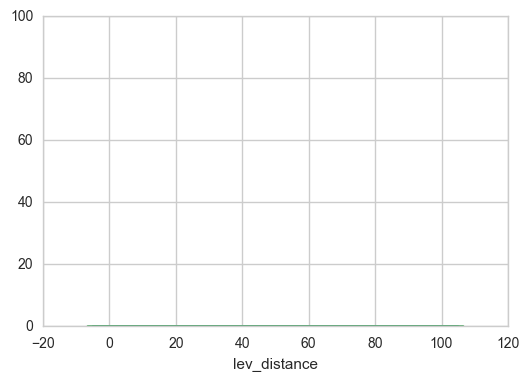

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# fig, ax = plt.subplots()
sns.set_style("whitegrid")
sns.distplot(x,label='TED')
sns.distplot(y,label='YT')
plt.ylim(0,100);